In [92]:
import xarray as xr
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15,8)

import pandas as pd
import os

#### Example: analyzing ERA5 relative humidity data

In [26]:
rh = xr.open_dataset("../data/humidity.nc").sel(expver=5)

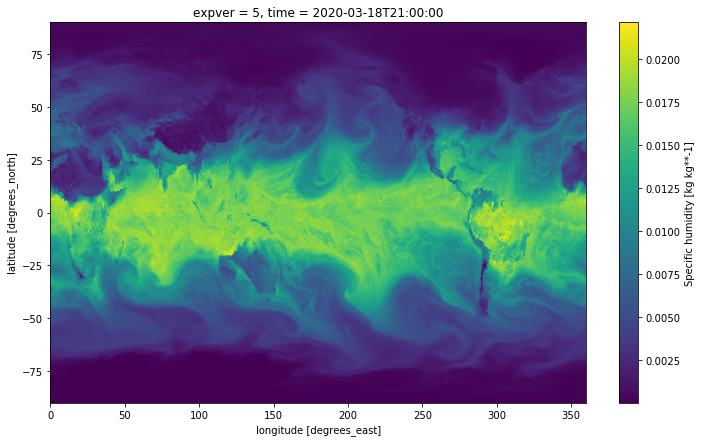

In [27]:
rh['q'].isel(time=-1).plot()
plt.savefig(f"../figures/rh_lastweek.png")

### Example: analyzing John Hopkins University Covid19 confirmed infections and deaths

In [87]:
dir_path = "../data/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"
daily = os.listdir(dir_path)

li = []
for day in daily:
    if ".csv" not in day: continue
    df_day = pd.read_csv(dir_path+day, index_col=None, header=0)
    df_day['date'] = day.split(".")[0]
    li.append(df_day)
    
df = pd.concat(li, axis=0, ignore_index=True, sort=False)
global_df = df.groupby('date').sum()

Text(0, 0.5, 'Global deaths')

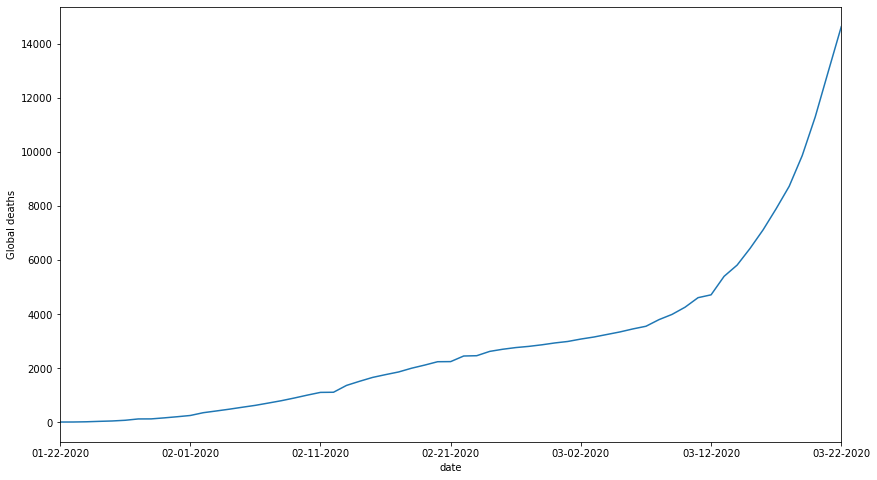

In [88]:
global_df['Deaths'].plot(x="date")
plt.ylabel("Global deaths")

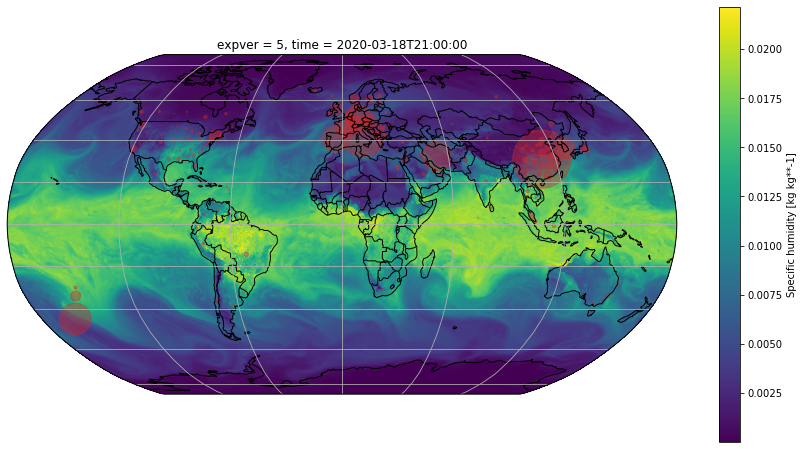

In [121]:
import cartopy
import cartopy.crs as ccrs
ortho = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

ex_date = "03-18-2020"
ex_df = df[df['date']==ex_date]

ax = plt.subplot(1, 1, 1, projection=ortho)

rh['q'].isel(time=-1).plot(ax=ax, transform=geo)
ax.scatter(ex_df['Longitude'], ex_df['Latitude'], ex_df['Confirmed']/20., color='C3', alpha=0.4, transform=geo)
ax.scatter([-149.25, -151.3, -160], [-30, -34, -45], [10., 100., 1000.], color='C3', alpha=0.4, transform=geo)

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.gridlines()

plt.savefig("../figures/rh_and_confirmed_cases.png", dpi=250, bbox_inches="tight")

### Compute daily mean relative humidity

In [ ]:
rh_daily = rh['q'].resample(time='1D').mean(dim='time')

/home/hdrake/.conda/envs/xmultigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [ ]:
rh_daily